<a href="https://www.kaggle.com/code/aisuko/lstm-for-time-series-data-forecasting?scriptVersionId=199801234" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Overview

Long Short-Term memory(LSTM).

# Load data

In [1]:
import numpy as np
import pandas as pd
import plotly.graph_objects as go
from sklearn.linear_model import BayesianRidge
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
import pandas_datareader as pdr

# Define the date range
start_date = '1960-01-01'
end_date = '2020-01-01'

# Fetch the S&P 500 data and drop any missing values
data = pdr.get_data_fred('SP500', start=start_date, end=end_date).dropna()

# Create a Plotly line plot to visualize the time series
fig = go.Figure()

# Add trace for the S&P 500 data
fig.add_trace(go.Scatter(x=data.index, y=data['SP500'], mode='lines', name='S&P 500'))

# Customize the layout
fig.update_layout(
    title='S&P 500 Index',
    xaxis_title='Date',
    yaxis_title='Value',
    template='plotly_white',
    autosize=False,
    width=1000,
    height=500
)

# Show the plot
fig.show()

# Preprocessing

In [2]:
def data_preprocessing(data, num_lags, train_test_split):
    x=[]
    y=[]
    for i in range(len(data)-num_lags):
        x.append(data[i:i+num_lags])
        y.append(data[i+num_lags])
    # convert the data to numpy arrays
    x=np.array(x)
    y=np.array(y)
    
    # split the data into training and testing sets
    split_index=int(train_test_split*len(x))
    x_train=x[:split_index]
    y_train=y[:split_index]
    x_test=x[split_index:]
    y_test=y[split_index:]
    
    return x_train, y_train, x_test, y_test

start_date='1960-01-01'
end_date='2020-01-01'

# set the time index if it's not already set
data = (pdr.get_data_fred('SP500', start = start_date, end = end_date).dropna())
# Perform differencing to make the data stationary
data_diff = data.diff().dropna()
# You can choose an appropriate split point based on your data
data_diff = np.reshape(np.array(data_diff), (-1))
x_train, y_train, x_test, y_test = data_preprocessing(data_diff, 100, 0.80)

In [3]:
# Setting the hyperparameters
num_lags = 100
train_test_split = 0.80
num_neurons_in_hidden_layers = 30
num_epochs = 10
batch_size = 32

# Reshape the data for LSTM input
x_train = x_train.reshape((-1, num_lags, 1))
x_test = x_test.reshape((-1, num_lags, 1))

# Define neural network

In [4]:
from keras.models import Sequential
from keras.layers import Dense, LSTM

# Create the LSTM model
model = Sequential()
# First LSTM layer
model.add(LSTM(units = num_neurons_in_hidden_layers, input_shape = (num_lags, 1)))
# Second hidden layer
model.add(Dense(num_neurons_in_hidden_layers, activation = 'relu'))  
# Output layer
model.add(Dense(units = 1))
# Compile the model
model.compile(loss = 'mean_squared_error', optimizer = 'adam')

/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



# Train the model

In [5]:
# Train the model
model.fit(x_train, y_train, epochs = num_epochs , batch_size = batch_size)

Epoch 1/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 430.5627
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 405.6650
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 369.1291
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 399.5537
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 434.3386
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 433.5634
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 428.2820
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 383.3032
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 434.1567
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 450.4293


In [6]:
# Predicting in-sample
y_predicted_train = np.reshape(model.predict(x_train), (-1, 1))
# Predicting out-of-sample
y_predicted = np.reshape(model.predict(x_test), (-1, 1))

31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


# Visualization the result

/tmp/ipykernel_17/3422759329.py:13: RuntimeWarning:

invalid value encountered in divide

/tmp/ipykernel_17/3422759329.py:14: RuntimeWarning:

invalid value encountered in divide

/tmp/ipykernel_17/3422759329.py:15: RuntimeWarning:

invalid value encountered in divide



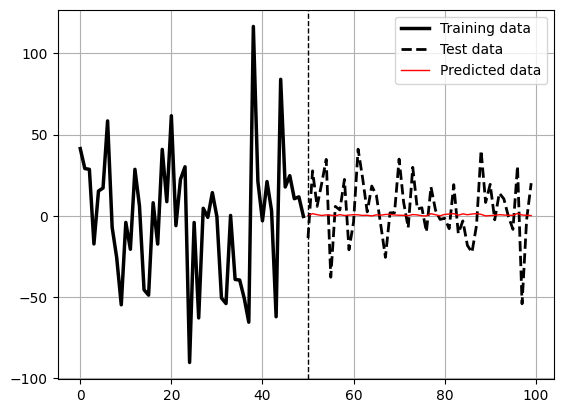

In [7]:
import matplotlib.pyplot as plt

def plot_train_test_values(window, train_window, y_train, y_test, y_predicted):
    prediction_window = window
    first = train_window
    second = window - first
    y_predicted = np.reshape(y_predicted, (-1, 1))
    y_test = np.reshape(y_test, (-1, 1))
    plotting_time_series = np.zeros((prediction_window, 3))
    plotting_time_series[0:first, 0] = y_train[-first:]
    plotting_time_series[first:, 1] = y_test[0:second, 0]
    plotting_time_series[first:, 2] = y_predicted[0:second, 0] 
    plotting_time_series[0:first, 1] = plotting_time_series[0:first, 1] / 0
    plotting_time_series[0:first, 2] = plotting_time_series[0:first, 2] / 0
    plotting_time_series[first:, 0] = plotting_time_series[first:, 0] / 0
    plt.plot(plotting_time_series[:, 0], label = 'Training data', color = 'black', linewidth = 2.5)
    plt.plot(plotting_time_series[:, 1], label = 'Test data', color = 'black', linestyle = 'dashed', linewidth = 2)
    plt.plot(plotting_time_series[:, 2], label = 'Predicted data', color = 'red', linewidth = 1)
    plt.axvline(x = first, color = 'black', linestyle = '--', linewidth = 1)
    plt.grid()
    plt.legend()

# plotting
y_test = np.reshape(y_test, (-1))
y_train = np.reshape(y_train, (-1))
plot_train_test_values(100, 50, y_train, y_test, y_predicted)

# Acknowledgement

* https://kaabar-sofien.medium.com/a-neural-network-algorithm-for-inflation-time-series-7450fff71c86
* https://www.kaggle.com/code/aisuko/xgboost2-0-for-time-series-forecasts
* https://www.kaggle.com/code/aisuko/time-series-forecasting-with-bayesian-regression